# Using ms2deepscore: How to load data, train a model, and compute similarities.

In [1]:
from pathlib import Path
import os

from matchms.importing import load_from_mgf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

from ms2deepscore import SpectrumBinner
from ms2deepscore.data_generators import DataGeneratorAllInchikeys
from ms2deepscore.models import SiameseModel
from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model

## Data loading

Here we define the file location of a small sample of spectrums as well as reference scores data.

In [2]:
TEST_RESOURCES_PATH = Path.cwd().parent / 'tests' / 'resources'
spectrums_filepath = str(TEST_RESOURCES_PATH / "pesticides_processed.mgf")
score_filepath = str(TEST_RESOURCES_PATH / "pesticides_tanimoto_scores.json")

Load processed spectrums from .mgf file. For processing itself see [matchms](https://github.com/matchms/matchms) documentation.
As example a very small dataset is used, for real use it is adviced to always use a large dataset >100.000 spectra. 
Also as simplification a validation set is used that is equal to the training data, for training a real model, this should not be the case.

In [3]:
spectrums_training = list(load_from_mgf(spectrums_filepath))
spectrums_validation = list(load_from_mgf(spectrums_filepath))

Load reference scores from a .json file. This is a Pandas DataFrame with reference similarity scores (=labels) for compounds identified by inchikeys. Columns and index should be inchikeys, the value in a row x column depicting the similarity score for that pair. Must be symmetric (reference_scores_df[i,j] == reference_scores_df[j,i]) and column names should be identical to the index.

In [4]:
tanimoto_scores_df = pd.read_json(score_filepath)

## Data preprocessing

Bin the spectrums using `ms2deepscore.SpectrumBinner`. In this binned form we can feed spectra to the model.

In [5]:
spectrum_binner = SpectrumBinner(10000, mz_min=10.0, mz_max=1000.0, peak_scaling=0.5, allowed_missing_percentage=100.0)
binned_spectrums_training = spectrum_binner.fit_transform(spectrums_training)
binned_spectrums_val = spectrum_binner.transform(spectrums_validation)

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 37178.34it/s]

Collect spectrum peaks...
Calculated embedding dimension: 1978.
Convert spectrums to binned spectrums...


Create a data generator that will generate batches of training examples.
Each training example consists of a pair of binned spectra and the corresponding reference similarity score. Pairs are sampled to ensure that the for 10 bins in tanimoto scores equal number of spectra are sampled. Also data augmentation takes place.

In [6]:
training_inchikeys = np.unique([s.get("inchikey")[:14] for s in spectrums_training])

same_prob_bins = list(zip(np.linspace(0, 0.9, 10), np.linspace(0.1, 1, 10)))
dimension = len(spectrum_binner.known_bins)
training_generator = DataGeneratorAllInchikeys(
    binned_spectrums_training, training_inchikeys, tanimoto_scores_df, dim=dimension,
    same_prob_bins=same_prob_bins, num_turns=2, augment_noise_max=10, augment_noise_intensity=0.01)

The value for num_turns is set from 1 (default) to 2
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_noise_max is set from 10 (default) to 10
The value for augment_noise_intensity is set from 0.01 (default) to 0.01


Create a data generatior that will generate pairs of binned spectra for the validation spectra. The settings are different from the settings for the training generator to ensure that a fixed dataset is generated were no data augmentation takes place. 

In [7]:
validation_inchikeys = np.unique([s.get("inchikey")[:14] for s in spectrums_validation])
validation_generator = DataGeneratorAllInchikeys(
    binned_spectrums_val, validation_inchikeys, tanimoto_scores_df, dim=dimension, same_prob_bins=same_prob_bins,
    num_turns=10, augment_removal_max=0, augment_removal_intensity=0, 
    augment_intensity=0, augment_noise_max=0, use_fixed_set=True)

The value for num_turns is set from 1 (default) to 10
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_removal_max is set from 0.3 (default) to 0
The value for augment_removal_intensity is set from 0.2 (default) to 0
The value for augment_intensity is set from 0.4 (default) to 0
The value for augment_noise_max is set from 10 (default) to 0
The value for use_fixed_set is set from False (default) to True


C:\Users\jonge094\Anaconda3\lib\site-packages\ms2deepscore\data_generators.py:180: UserWarning: When using a fixed set, data will not be shuffled
  warnings.warn('When using a fixed set, data will not be shuffled')


## Model training

Initialize a SiameseModel. It consists of a dense 'base' network that produces an embedding for each of the 2 inputs. The 'head' model computes the cosine similarity between the embeddings.

In [8]:
model = SiameseModel(spectrum_binner, base_dims=(500, 500), embedding_dim=200,
                         dropout_rate=0.2)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01), metrics=["mae", tf.keras.metrics.RootMeanSquaredError()])

# Save best model and include earlystopping
earlystopper_scoring_net = EarlyStopping(monitor='val_loss', mode="min", patience=10, verbose=1, restore_best_weights=True)
model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 1978)]            0         
                                                                 
 dense1 (Dense)              (None, 500)               989500    
                                                                 
 normalization1 (BatchNormal  (None, 500)              2000      
 ization)                                                        
                                                                 
 dense2 (Dense)              (None, 500)               250500    
                                                                 
 normalization2 (BatchNormal  (None, 500)              2000      
 ization)                                                        
                                                                 
 dropout2 (Dropout)          (None, 500)               0      

Train the model. The model will continue for 150 epochs or will stop if the validation loss did not decrease for 10 epochs.

In [9]:
history = model.model.fit(training_generator, validation_data=validation_generator,
                          epochs=150, verbose=1, callbacks=[earlystopper_scoring_net])

Epoch 1/150
2/2 [==============================] - 1s 420ms/step - loss: 0.0834 - mae: 0.1847 - root_mean_squared_error: 0.2428 - val_loss: 0.0555 - val_mae: 0.1478 - val_root_mean_squared_error: 0.1811
Epoch 2/150
2/2 [==============================] - 0s 135ms/step - loss: 0.0735 - mae: 0.1782 - root_mean_squared_error: 0.2264 - val_loss: 0.0544 - val_mae: 0.1410 - val_root_mean_squared_error: 0.1816
Epoch 3/150
2/2 [==============================] - 0s 205ms/step - loss: 0.0707 - mae: 0.1808 - root_mean_squared_error: 0.2223 - val_loss: 0.0601 - val_mae: 0.1549 - val_root_mean_squared_error: 0.1975
Epoch 4/150
2/2 [==============================] - 0s 202ms/step - loss: 0.0491 - mae: 0.1271 - root_mean_squared_error: 0.1671 - val_loss: 0.0652 - val_mae: 0.1678 - val_root_mean_squared_error: 0.2090
Epoch 5/150
2/2 [==============================] - 0s 148ms/step - loss: 0.0467 - mae: 0.1266 - root_mean_squared_error: 0.1577 - val_loss: 0.0750 - val_mae: 0.1893 - val_root_mean_squared

Save the model (if you want to)

In [10]:
model_file_name = os.path.join(TEST_RESOURCES_PATH, "ms2deepscore_model.hdf5")
model.save(model_file_name)

Code to later lode in the model again


In [11]:
model = load_model(model_file_name)

Plot the validation and training loss, to check for overfitting.

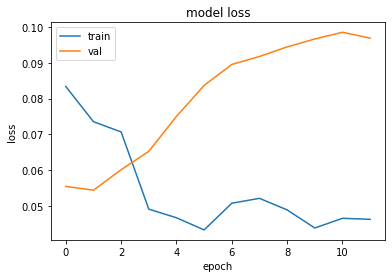

In [12]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model inference

Calculate similariteis for a pair of spectra

In [13]:
similarity_measure = MS2DeepScore(model)
score = similarity_measure.pair(spectrums_validation[0], spectrums_validation[1])
print(score)

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


0.6926684862381262


Calculate similarities for a 3x3 matrix of spectra

In [14]:
scores = similarity_measure.matrix(spectrums_validation[:3], spectrums_validation[:3])
print(scores)

Calculating vectors of reference spectrums: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.10it/s]


[[1.         0.69266849 0.59288358]
 [0.69266849 1.         0.50841891]
 [0.59288358 0.50841891 1.        ]]
